In [1]:
!pip install -q malariagen_data

In [2]:
import malariagen_data
import dask.array as da
import numpy as np
import functools
import allel

In [3]:
ag3 = malariagen_data.Ag3("gs://vo_agam_release/")

In [9]:
autosomes = "2R", "2L", "3R", "3L"

In [28]:
@functools.lru_cache(maxsize=None)
def accessible_windows(mask, threshold=.9):
    xx = []
    for contig in autosomes:
        is_accessible = ag3.is_accessible(contig=contig, site_mask=mask)
        x = allel.moving_statistic(is_accessible, statistic=np.mean, size=300)
        xx.append(x)
    v = np.concatenate(xx)
    return v > threshold


sp2mask = {
    'gambiae': 'gamb_colu',
    'coluzzii': 'gamb_colu',
    'intermediate_gambiae_coluzzii': 'gamb_colu',
    'arabiensis': 'arab',
}


@functools.lru_cache(maxsize=None)
def compute_cov_var(sample_sets):
    
    # load sample metadata
    df_samples = ag3.sample_metadata()
    species = df_samples['species'].values
    
    # load normalised coverage for all autosomes
    ncs = []
    for contig in autosomes:
        ds = ag3.cnv_hmm(contig=contig, sample_sets=sample_sets)
        nc = ds['call_NormCov'].data
        ncs.append(nc[:-1, :])  # exclude final window, may be short
    nc = da.concatenate(ncs, axis=0).compute()
    out = np.zeros(nc.shape[1], dtype=float)
    
    for j in range(nc.shape[1]):
        x = nc[:, j]  # exclude last window
        
        # look up species
        sp = species[j]
        mask = sp2mask[sp]
        
        # locate windows where copy number state is called - should have been already filtered for mq0 and extreme gc
        loc_called = ~np.isnan(x)  
        
        # locate 90% accessible windows
        loc_accessible = accessible_windows(mask=mask, threshold=.9)
        
        # sanity check
        assert loc_called.shape == loc_accessible.shape, (loc_called.shape, loc_accessible.shape)

        # apply filtering
        xn = x[loc_called & loc_accessible]
        
        # exclude to 1%
        pc99 = np.percentile(xn, 99)
        xnn = xn[xn < pc99]
        
        # compute variance and store
        v = np.var(xnn)
        out[j] = v
        
    return out
    

In [29]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

In [38]:
def compare_variances(sample_sets):

    me = compute_cov_var(sample_sets=sample_sets) 
    
    # we've stored Eric's precomputed variance values in the discordant reads
    # datasets, access them from there
    ds_dr = ag3.cnv_discordant_read_calls(contig="2R", sample_sets=sample_sets)
    eric = ds_dr['sample_coverage_variance'].values
    
    fig, ax = plt.subplots(figsize=(4, 4))
    n = min(me.min(), eric.min())
    x = max(me.max(), eric.max())
    ax.plot([n, x], [n, x], '--')
    ax.plot(me, eric, 'bo')
    ax.set_xlabel('me')
    ax.set_ylabel('Eric')
    ax.set_title(sample_sets)
    ax.axhline(0.2)


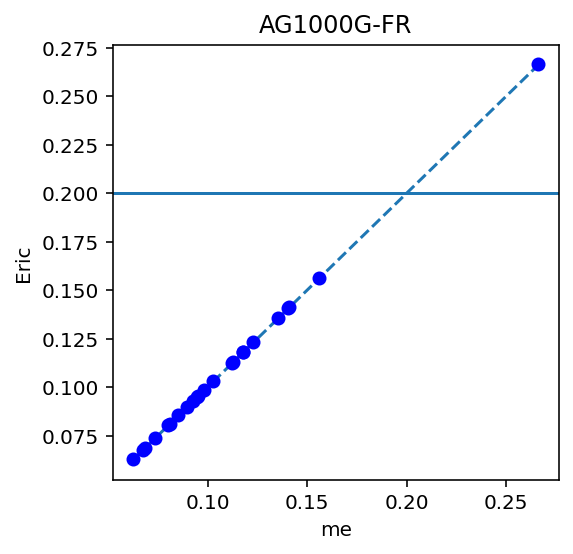

In [39]:
compare_variances("AG1000G-FR")

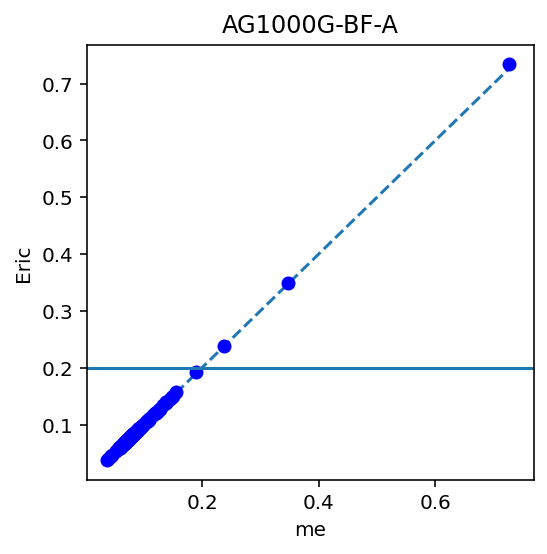

In [40]:
compare_variances("AG1000G-BF-A")

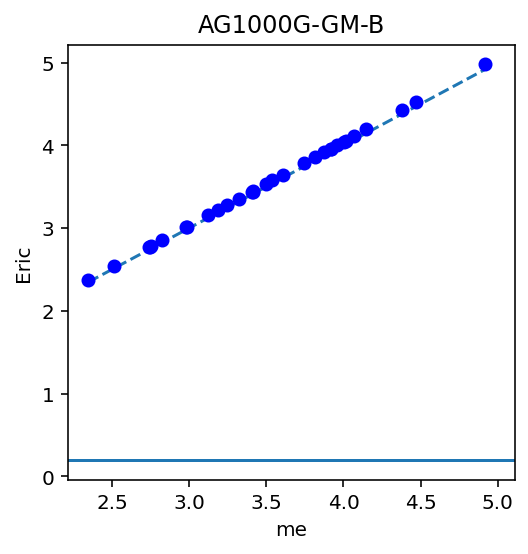

In [41]:
compare_variances("AG1000G-GM-B")